
**<p><font size="5">Derin Öğrenme Yöntemleriyle Göğüs Röntgeni Görüntülerinden Otomatik Zatürre (Pnömoni) Tespiti</font></p>**


**Giriş**

1. HDF5 Veri Seti Oluşturma ve Ön İşleme
2. HDF5 Dosyasından Görüntü ve Etiket Verilerinin NumPy Dizilerine Aktarılması

**Ön İşleme**

3. Görüntü Verilerinin Normalizasyonu ve Eğitim-Doğrulama-Test Kümelerine Ayrılması 
4. CNN Eğitimi Öncesi Göğüs Röntgeni Verilerinin Görsel İncelenmesi
   
**Modellerin Oluşturulması ve Eğitilmesi**

5. Model 1’in Oluşturulması ve Eğitilmesi (Özel CNN Modeli) 
6. Model 2’nin Eğitilmesi (Tek Aşamalı Fine-Tuning Uygulanan ResNet-50 Modeli) 
7. Model 3’ün Eğitilmesi (İki Aşamalı Fine-Tuning Uygulanan ResNet-50 Modeli)
   
**Değerlendirme**

8. Model Değerlendirmeleri  

# 1) HDF5 Veri Seti Oluşturma ve Ön İşleme

**1) Görüntü Ön İşleme (Preprocessing):**
Her bir röntgen görüntüsü gri tonlamaya (grayscale) dönüştürülmekte ve 180×180 boyutuna yeniden ölçeklendirilmektedir. Ardından görüntüler, NumPy dizisi formatına çevrilmektedir.

**2) Sınıf Etiketleme:**
Görüntüler iki sınıfa ayrılmaktadır:

    - NORMAL → Etiket 0
    - PNEUMONIA → Etiket 1


**3) Veri Toplama:**
Kaggle veri dizinindeki ilgili klasörlerden (NORMAL ve PNEUMONIA) tüm uygun görüntü dosyaları (.jpeg, .jpg, .png) otomatik olarak toplanmaktadır.


**4) HDF5 Veri Seti Oluşturma:**
Toplanan görüntüler ve etiketler, Kaggle çalışma dizini (/kaggle/working) içerisinde x_ray_full_dataset.h5 adlı tek bir HDF5 dosyasında saklanmaktadır.


**5) Verimlilik ve Organizasyon:**
Bu yaklaşım sayesinde:

    - Büyük veri setleri daha hızlı yüklenebilir,
    - Dosya yönetimi kolaylaşır,
    - Eğitim ve test süreçleri daha verimli hale gelir.

In [6]:
import h5py
import numpy as np
from PIL import Image
import os



#  1. Görüntüyü ön işleme fonksiyonu
def preprocess_image(image_path, target_size=(180, 180)):
    img = Image.open(image_path).convert('L')  # görüntüyü gri tonlamaya çevir (grayscale)
    img = img.resize(target_size, Image.Resampling.LANCZOS)  # görüntüyü hedef boyuta yeniden boyutlandır
    img_array = np.array(img, dtype=np.uint8)  # görüntüyü numpy dizisine çevir
    return img_array

#  2. Kaggle'da HDF5 veri seti oluşturma fonksiyonu
def create_hdf5_dataset_kaggle(image_folder, hdf5_file, target_size=(180, 180)):
    classes = ['NORMAL', 'PNEUMONIA']  # iki sınıf: NORMAL ve PNEUMONIA
    image_paths = []
    labels = []

    # Kaggle veri klasörlerindeki görüntüleri toplama
    for label, class_name in enumerate(classes):
        class_folder = os.path.join(image_folder, class_name)
        if os.path.isdir(class_folder):
            for image_name in os.listdir(class_folder):
                # sadece jpeg, jpg veya png dosyalarını al
                if image_name.lower().endswith(('.jpeg', '.jpg', '.png')):
                    image_paths.append(os.path.join(class_folder, image_name))
                    labels.append(label)  # class index'i etikete ekle (0-normal, 1-pneumonia)

    num_images = len(image_paths)
    print(f"Toplam görüntü sayısı: {num_images}")

    # Kaggle /working dizininde HDF5 dosyası oluşturma
    with h5py.File(hdf5_file, 'w') as hf:
        img_shape = (num_images, target_size[0], target_size[1])
        hf.create_dataset('images', shape=img_shape, dtype='uint8')  # görüntü veri kümesi oluştur
        hf.create_dataset('labels', shape=(num_images,), dtype='uint8')  # etiket veri kümesi oluştur

        # tüm görüntüleri işleyip HDF5 dosyasına kaydet
        for i, image_path in enumerate(image_paths):
            img_array = preprocess_image(image_path, target_size)
            hf['images'][i] = img_array  # görüntüyü kaydet
            hf['labels'][i] = labels[i]  # etiketi kaydet

            if i % 200 == 0:
                print(f"{i}/{num_images} görüntü işlendi...")

    print(f"\n✔ Tüm görüntüler başarıyla kaydedildi: {hdf5_file}")

#  3. Kaggle veri setinin klasör yolu
image_folder = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'

#  4. HDF5 dosyasının kayıt yeri (/kaggle/working içine kaydedilir)
hdf5_file = '/kaggle/working/x_ray_full_dataset.h5'

#  5. Fonksiyonu çalıştır
create_hdf5_dataset_kaggle(image_folder, hdf5_file, target_size=(180, 180))

Toplam görüntü sayısı: 5216
0/5216 görüntü işlendi...
200/5216 görüntü işlendi...
400/5216 görüntü işlendi...
600/5216 görüntü işlendi...
800/5216 görüntü işlendi...
1000/5216 görüntü işlendi...
1200/5216 görüntü işlendi...
1400/5216 görüntü işlendi...
1600/5216 görüntü işlendi...
1800/5216 görüntü işlendi...
2000/5216 görüntü işlendi...
2200/5216 görüntü işlendi...
2400/5216 görüntü işlendi...
2600/5216 görüntü işlendi...
2800/5216 görüntü işlendi...
3000/5216 görüntü işlendi...
3200/5216 görüntü işlendi...
3400/5216 görüntü işlendi...
3600/5216 görüntü işlendi...
3800/5216 görüntü işlendi...
4000/5216 görüntü işlendi...
4200/5216 görüntü işlendi...
4400/5216 görüntü işlendi...
4600/5216 görüntü işlendi...
4800/5216 görüntü işlendi...
5000/5216 görüntü işlendi...
5200/5216 görüntü işlendi...

✔ Tüm görüntüler başarıyla kaydedildi: /kaggle/working/x_ray_full_dataset.h5


# 2) HDF5 Dosyasından Görüntü ve Etiket Verilerinin NumPy Dizilerine Aktarılması

In [7]:
# Bu kod, HDF5 dosyasını açıp içindeki görüntüleri (X) ve etiketleri (y)
# NumPy dizilerine dönüştürür. Bu diziler model eğitiminde doğrudan kullanılabilir.

# "x_ray_full_dataset.h5" dosyasını numpy dizilerine dönüştürme
import h5py
import numpy as np

# HDF5 dosyasını okuma modunda aç
with h5py.File('/kaggle/working/x_ray_full_dataset.h5', 'r') as h5_file:
    
    # "images" veri kümesini NumPy dizisine çevir
    X = np.array(h5_file['images'])
    
    # "labels" veri kümesini NumPy dizisine çevir
    y = np.array(h5_file['labels'])

# X ve y dizilerinin boyutlarını ekrana yazdır
print(X.shape, y.shape)

(5216, 180, 180) (5216,)


# 3) Görüntü Verilerinin Normalizasyonu ve Eğitim-Doğrulama-Test Kümelerine Ayrılması

In [8]:
# Bu kod, görüntü verilerini normalize eder, kanal boyutu ekler
# ve verileri eğitim, doğrulama ve test kümelerine böler.
# Bu adım, CNN modelinin eğitimi için veriyi hazır hale getirir.

from sklearn.model_selection import train_test_split

# Görüntüleri normalize et (0-255 → 0-1 aralığına dönüştür)
# Piksel değerleri sabit olarak 0–255 aralığından 0–1 aralığına ölçeklendiği için
# bu normalizasyon işlemi veri sızıntısına veya overfitting’e yol açmaz.

X = X / 255.0

# Grayscale görüntüler için kanal boyutu ekle (180,180 → 180,180,1)
X = np.expand_dims(X, axis=-1)

# Veriyi eğitim (%80) ve test (%20) olarak ayır
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

# Eğitim verisinin %10’unu doğrulama setine ayır
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=0
)

# Ayrılmış veri kümelerinin boyutlarını yazdır
print(f"X_train.shape: {X_train.shape}   y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}   y_test.shape: {y_test.shape}")
print(f"X_val.shape: {X_val.shape}   y_val.shape: {y_val.shape}")

X_train.shape: (3754, 180, 180, 1)   y_train.shape: (3754,)
X_test.shape: (1044, 180, 180, 1)   y_test.shape: (1044,)
X_val.shape: (418, 180, 180, 1)   y_val.shape: (418,)


# 4) CNN Eğitimi Öncesi Göğüs Röntgeni Verilerinin Görsel İncelenmesi

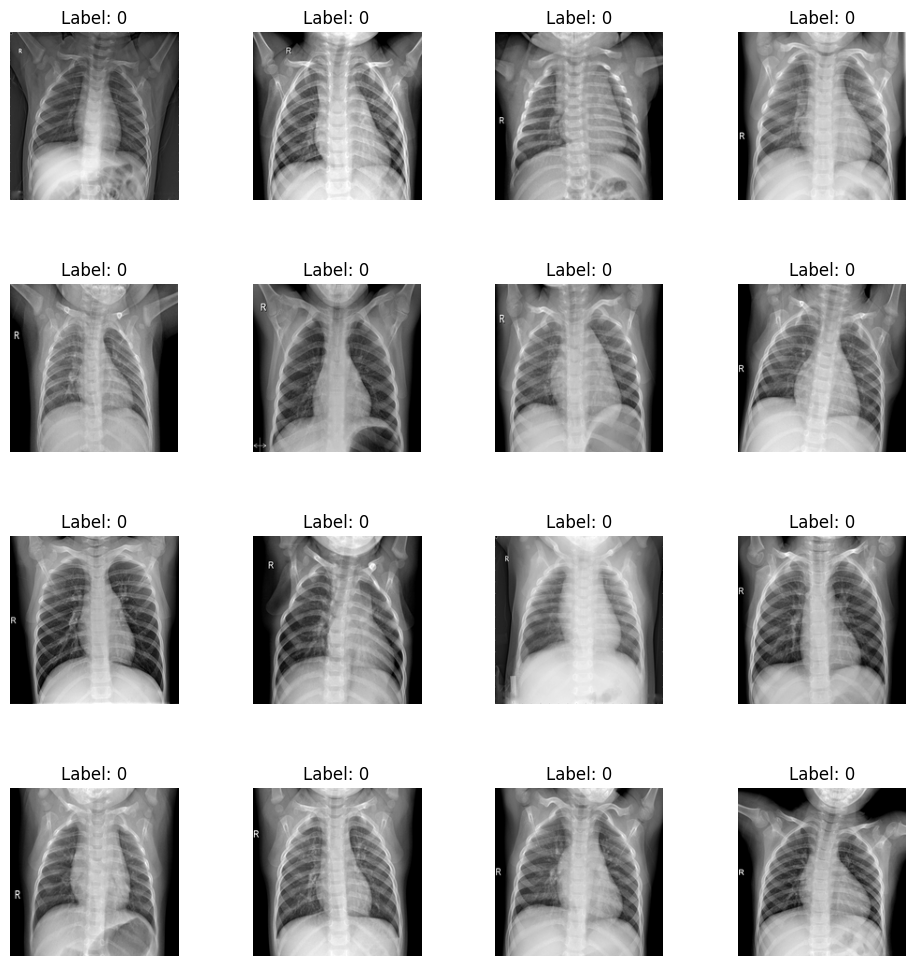

In [6]:
# Bu kod, X ve y veri setlerinden göğüs röntgeni (X-ray) görüntülerini
# 4x4’lük bir grid yapısı içinde görselleştirir. 
# Her görüntü "squeeze()" yöntemiyle ekstra boyutlardan temizlenir 
# ve gri tonlamada (grayscale) ekranda gösterilir. 
# Her görüntünün üstünde o görüntünün etiketi (0 veya 1) yazdırılır.
# Bu fonksiyon, veri setinin doğru şekilde yüklendiğini kontrol etmek için kullanılır.

import numpy as np
import matplotlib.pyplot as plt

# X-ray görüntülerini grid şeklinde ekranda gösteren fonksiyon
def display_x_rays(X, y, rows=4, cols=4):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))  # 4x4 subplot oluşturma
    fig.subplots_adjust(hspace=0.5)                          # Görüntüler arası boşluk ayarı

    for i, ax in enumerate(axes.flat):
        ax.imshow(X[i].squeeze(), cmap='gray')               # Görüntüyü sıkıştırıp gri tonlamada göster
        ax.set_title(f'Label: {y[i]}')                       # Görüntünün etiketini başlık olarak yaz
        ax.axis('off')                                       # Eksenleri kapat (temiz görünüm)
    
    plt.show()                                               # Tüm görüntüleri göster

# 16 görüntüyü ekranda göster
display_x_rays(X, y)

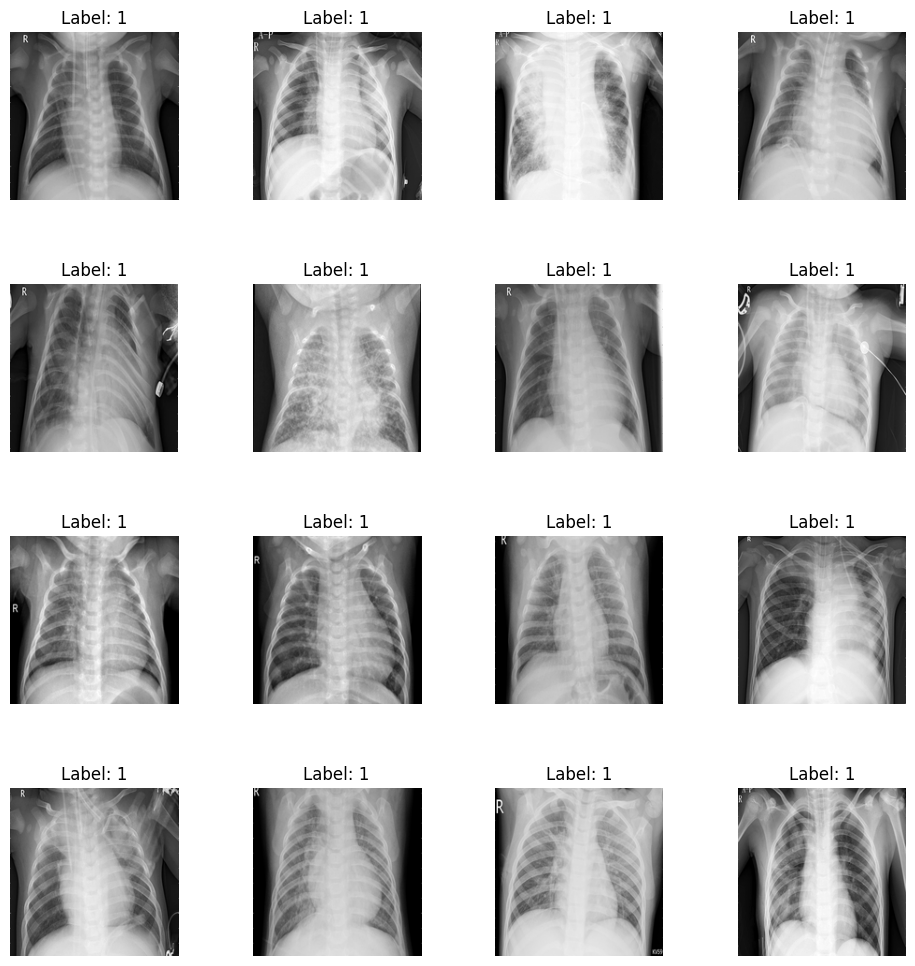

In [7]:
# 16 adet görüntü gösterme
import numpy as np
import matplotlib.pyplot as plt

# X-ray görüntülerini grid formatında gösteren fonksiyon
def display_x_rays(X, y, rows=4, cols=4):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))  # 4x4 subplot alanı oluşturma
    fig.subplots_adjust(hspace=0.5)                          # Görüntüler arası boşluk ayarı

    for i, ax in enumerate(axes.flat):
        ax.imshow(X[i].squeeze(), cmap='gray')               # Görüntüyü sıkıştırıp gri tonlamada göster
        ax.set_title(f'Label: {y[i]}')                       # Etiketi başlık olarak yaz
        ax.axis('off')                                       # Eksenleri gizle
    
    plt.show()                                               # Görüntüleri ekranda göster

# Veri setinin 5000. indeksinden itibaren son 16 görüntüyü göster
display_x_rays(X[5000:], y[5000:])


# 5) Model 1’in Oluşturulması ve Eğitilmesi (Özel CNN Modeli)

- Model 1’in oluşturulması
- Model 1’in eğitilmesi (modelin eğitimi yaklaşık 1 saat 45 dakika sürmüştür)
- Model 1’in kaydedilmesi
- Kaydedilen Model 1’in yeniden yüklenmesi
- Model 1’in değerlendirilmesi (%95.6 doğruluk elde edilmiştir)

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2

In [4]:
# Model 1'i oluşturan fonksiyon (Custom CNN)
def build_model():
    model = Sequential()

    # 1. Evrişim katmanı: 32 filtre ile temel özellik çıkarımı
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 2. Evrişim katmanı: 64 filtre ile daha karmaşık özellikler
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 3. Evrişim katmanı: 128 filtre ile derin özellik çıkarımı
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Çok boyutlu özellik haritalarını tek boyutlu vektöre çevir
    model.add(Flatten())

    # Tam bağlı katman
    model.add(Dense(128, activation='relu'))

    # Overfitting’i azaltmak için Dropout (%50)
    model.add(Dropout(0.5))

    # Çıkış katmanı (binary sınıflandırma için sigmoid)
    model.add(Dense(1, activation='sigmoid'))

    # Modeli derle
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Modeli oluştur ve özetini yazdır
model = build_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 178, 178, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,646,529 (25.35 MB)

 Trainable params: 6,646,529 (25.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Model 1 eğitilmesi
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.7355 - loss: 0.5519 - val_accuracy: 0.9041 - val_loss: 0.2707
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.8849 - loss: 0.2628 - val_accuracy: 0.9062 - val_loss: 0.2649
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.9214 - loss: 0.1977 - val_accuracy: 0.9254 - val_loss: 0.2208
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.9300 - loss: 0.1801 - val_accuracy: 0.9254 - val_loss: 0.2227
Epoch 5/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.9375 - loss: 0.1860 - val_accuracy: 0.9318 - val_loss: 0.2150
Epoch 6/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - accuracy: 0.9406 - loss: 0.1632 - val_accuracy: 0.9126 - val_loss: 0.2097
Epoch 7/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.9480 - loss: 0.1389 - val_accuracy: 0.9254 - val_loss: 0.1989
Epoch 8/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.9557 - loss: 0.1291 - val_accu

In [ ]:
# Model 1 kaydedilmesi (Keras formatında)
model.save('pneumonia_detection_model.keras')

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2

In [ ]:
# Keras formatından Model 1 yükleme
model = tf.keras.models.load_model('pneumonia_detection_model.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Model 1'i değerlendirme
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

37/37 ━━━━━━━━━━━━━━━━━━━━ 22s 584ms/step - accuracy: 0.9539 - loss: 0.1189
Test Accuracy: 0.9564846158027649


# 6) Model 2’nin Eğitilmesi (Tek Aşamalı Fine-Tuning Uygulanan ResNet-50 Modeli)

Önceki bölümde Model 1’in (Özel CNN) oluşturulması ve eğitilmesi tamamlanmıştır. Şimdi, ünlü ResNet-50 modeline dayanan Model 2’ye geçiyoruz. ResNet-50, görüntü sınıflandırma konusunda oldukça başarılı olan bir Evrişimsel Sinir Ağıdır (CNN). Eğitim sürecini hızlandırmak amacıyla bu önceden eğitilmiş modeli başlangıç noktası olarak kullanıyoruz. Daha sonra, modeli kendi kullanım amacımıza (zatürre tespiti) uyarlamak için modelin son birkaç katmanı çıkarılarak ince ayar (fine-tuning) yapılmaktadır.

Buna ek olarak, orijinal model olan Model 1 (Özel CNN), gri tonlamalı X-ray görüntüleri kullandığımız için tek bir renk kanalını giriş olarak almaktadır. Ancak ResNet-50 modeli üç renk kanalına (RGB) sahip girdiler beklemektedir. Bu nedenle, ResNet-50’nin giriş şekliyle uyumlu olması için verilerimiz üç kez birleştirilerek her bir RGB kanalı için çoğaltılmıştır.

Aşağıdaki hücrelerde şu işlemler gerçekleştirilmektedir:

- Model 2’nin oluşturulması (ResNet-50 modelinin yüklenmesi ve değiştirilmesi)
- Model 2’nin eğitilmesi (Model 2’nin eğitimi, Model 1’e kıyasla çok daha hızlı gerçekleşmiştir)
- Model 2’nin kaydedilmesi
- Model 2’nin tekrar yüklenmesi
- Model 2’nin değerlendirilmesi (%90,1 doğruluk)

In [ ]:
# Bu hücrede, önceden eğitilmiş ResNet-50 modeli yüklenir ve Model 2 oluşturulur

# ImageNet üzerinde eğitilmiş ResNet-50 modelini yükle
# include_top=False → ImageNet'e ait son sınıflandırma katmanlarını çıkarır
# input_shape=(180,180,3) → Model RGB (3 kanallı) görüntü bekler
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

# Temel (base) modeldeki tüm katmanları dondur
# Böylece bu katmanların ağırlıkları eğitim sırasında güncellenmez
# Bu aşama feature extraction olarak adlandırılır
for layer in base_model.layers:
    layer.trainable = False

# ResNet-50'nin çıktısını al
x = base_model.output

# Global Average Pooling uygula
# Bu katman, özellik haritalarını tek bir vektöre indirger
# ve parametre sayısını azaltarak overfitting riskini düşürür
x = GlobalAveragePooling2D()(x)

# Tam bağlı (Dense) katman ekle
# 1024 nöron ile daha güçlü karar verme yeteneği sağlanır
x = Dense(1024, activation='relu')(x)

# Çıkış katmanı
# Sigmoid aktivasyon fonksiyonu ile binary sınıflandırma yapılır
# Çıkış değeri 0 ile 1 arasında olur
x = Dense(1, activation='sigmoid')(x)

# Giriş ve çıkışları birleştirerek nihai modeli oluştur
model = Model(inputs=base_model.input, outputs=x)

# Modeli derle
# Adam optimizer küçük bir öğrenme oranı ile kullanılır
# Binary crossentropy, iki sınıflı problemler için uygundur
# Accuracy performans metriği olarak seçilmiştir
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Modelin mimarisini ve parametre sayılarını ekrana yazdır
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 180, 180, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 186, 186, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 90, 90, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 90, 90, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 90, 90, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 92, 92, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 45, 45, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 45, 45, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 45, 45, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 45, 45, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 45, 45, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 45, 45, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 45, 45, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 45, 45, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 45, 45, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Model 2 eğitilmesi
history = model.fit(
    np.concatenate((X_train,X_train,X_train), axis=3), y_train,
    batch_size=32,
    epochs=30,
)

Epoch 1/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - accuracy: 0.7239 - loss: 0.5778
Epoch 2/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.7256 - loss: 0.5302
Epoch 3/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.7433 - loss: 0.4894
Epoch 4/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.7633 - loss: 0.4588
Epoch 5/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.7869 - loss: 0.4377
Epoch 6/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.7919 - loss: 0.4228
Epoch 7/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.8059 - loss: 0.4025
Epoch 8/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.8252 - loss: 0.3799
Epoch 9/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.8243 - loss: 0.3798
Epoch 10/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.8493 - loss: 0.3545
Epoch 11/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.8403 - loss: 0.3539
Epoch 12/30
132/132 ━━━━━━━━━━━━━━━━

In [ ]:
# Model 2 kaydedilmesi (Keras formatında)
model.save('v1_resnet50.keras')

In [ ]:
# Model 2, Keras formatından yüklenmesi
model = tf.keras.models.load_model('v1_resnet50.keras')

In [ ]:
# Model 2 değerlendirilmesi
test_loss, test_acc = model.evaluate(np.concatenate((X_test,X_test,X_test), axis=3), y_test)
print(f'Test Accuracy: {test_acc}')

37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 0.9073 - loss: 0.2316
Test Accuracy: 0.9010238647460938


# 7) Model 3’ün Eğitilmesi (İki Aşamalı Fine-Tuning Uygulanan ResNet-50 Modeli)

Bu bölümde incelenen son model, daha önce kullanılan ResNet-50 modeline dayanan bir başka fine-tuning uygulanmış modeldir. Ancak Model 3, iki aşamalı fine-tuning sürecinden geçirilmiş olması bakımından önceki modellerden ayrılmaktadır. İlk aşama, önceki modelde uygulanan fine-tuning yaklaşımına benzerken, ikinci aşamada ek katmanların açılmasıyla birlikte daha fazla ağırlık parametresinin güncellenmesine izin verilmiştir.

Aşağıdaki hücrelerde şu işlemler gerçekleştirilmiştir:

- Fine-Tuning’in Birinci Aşaması
- Fine-Tuning’in İkinci Aşaması
- Model 3’ün Kaydedilmesi, Yeniden Yüklenmesi ve Değerlendirilmesi (%93,3 doğruluk)

## 7.1) Fine-Tuning’in Birinci Aşaması

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam

In [ ]:
# Temel ResNet-50 modeli yüklenmesi
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(180, 180, 3))
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 180, 180, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 186, 186, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 90, 90, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 90, 90, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 90, 90, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 92, 92, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 45, 45, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 45, 45, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 45, 45, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 45, 45, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 45, 45, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 45, 45, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 45, 45, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 45, 45, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 45, 45, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# Temel (base) modeldeki tüm katmanları dondur
for layer in base_model.layers:
    layer.trainable = False

# add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 180, 180, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 186, 186, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 90, 90, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 90, 90, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 90, 90, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 92, 92, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 45, 45, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 45, 45, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 45, 45, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 45, 45, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 45, 45, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 45, 45, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 45, 45, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 45, 45, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 45, 45, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Model eğitilmesi
history = model.fit(
    np.concatenate((X_train,X_train,X_train), axis=3), y_train,
    batch_size=32,
    epochs=10,
)

Epoch 1/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 25s 88ms/step - accuracy: 0.7073 - loss: 0.6082
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.7332 - loss: 0.5925
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7357 - loss: 0.5872
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7227 - loss: 0.5973
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.7263 - loss: 0.5936
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.7264 - loss: 0.5905
Epoch 7/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.7162 - loss: 0.6045
Epoch 8/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.7293 - loss: 0.5901
Epoch 9/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.7283 - loss: 0.5955
Epoch 10/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.7325 - loss: 0.5869


In [ ]:
# modeli kaydet (Keras formatında)
model.save('v2_resnet50.keras')

## 7.2) Fine-Tuning’in ikinci Aşaması

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('v2_resnet50.keras')

In [ ]:
from tensorflow.keras.optimizers import Adam

# Modelin ilk (daha genel özellikler öğrenen) katmanlarını dondur
# Son 23 katman hariç tüm katmanlar eğitime kapatılır
for layer in model.layers[:-23]:
    layer.trainable = False

# Modelin son 23 katmanını eğitime aç
# Bu katmanlar, göreve özel özelliklerin daha iyi öğrenilmesini sağlar
for layer in model.layers[-23:]:
    layer.trainable = True

# Modeli tekrar derle
# Çok küçük bir öğrenme oranı kullanılır, çünkü önceden eğitilmiş ağırlıklar
# hassas şekilde güncellenecektir
model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [4]:
import numpy as np

# Fine-Tuning işlemini ikinci aşamada devam ettir
# Gri tonlamalı görüntüler ResNet-50 ile uyumlu olması için
# üç kanallı (RGB) formata dönüştürülür
history_finetuned = model.fit(
    np.concatenate((X_train, X_train, X_train), axis=3),  # (1 kanal → 3 kanal)
    y_train,                                              # eğitim etiketleri
    batch_size=32,                                        # her adımda kullanılan görüntü sayısı
    epochs=10,                                            # ince ayar için epoch sayısı
)

Epoch 1/10
132/132 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46s 135ms/step - accuracy: 0.8219 - loss: 0.3832
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.9415 - loss: 0.1589
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.9518 - loss: 0.1210
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 0.9487 - loss: 0.1271
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - accuracy: 0.9648 - loss: 0.1035
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - accuracy: 0.9639 - loss: 0.0968
Epoch 7/10
132/132 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.9651 - loss: 0.0903
Epoch 8/10
132/132 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.9654 - loss: 0.0897
Epoch 9/10
132/132 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.9706 - loss: 0.0820
Epoch 10/10
132/132 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.9634 - loss: 0.0893
132/132


## 7.3) Model 3’ün Kaydedilmesi, Yüklenmesi ve Değerlendirilmesi

In [ ]:
# Model 3’ü kaydet (Keras formatında)
model.save('v3_resnet50.keras')

In [ ]:
# Model 3, Keras formatından yüklenmesi
model = tf.keras.models.load_model('v3_resnet50.keras')

In [ ]:
# Model 3 değerlendirilmesi
test_loss, test_acc = model.evaluate(np.concatenate((X_test,X_test,X_test), axis=3), y_test)
print(f'Test Accuracy: {test_acc}')

37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.9247 - loss: 0.2092
Test Accuracy: 0.9334471225738525


# 8. Model Değerlendirmeleri

Şimdiye kadar üç farklı model oluşturulmuş ve eğitilmiştir:

- Model 1: Özel CNN (Custom CNN)
- Model 2: Tek aşamalı fine-tuning uygulanan ResNet-50 modeli
- Model 3: İki aşamalı fine-tuning uygulanan ResNet-50 modeli

Bu bölümde, oluşturulan üç model aşağıdaki performans ölçütleri kullanılarak daha ayrıntılı bir şekilde değerlendirilecektir:

- Doğruluk (Accuracy)
- Kesinlik (Precision)
- Duyarlılık (Recall)
- F1 Skoru (F1 Score)

Ayrıca, bu ölçütleri özetleyen ve modellerin performanslarını daha derinlemesine anlamamıza yardımcı olan karışıklık matrisleri (Confusion Matrices) oluşturulacaktır.

## 8.1 Model 1: Custom CNN

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Accuracy: 0.9564846416382252
Precision: 0.9577464788732394
Recall: 0.9819494584837545
F1 Score: 0.9696969696969697

Confusion Matrix:
 [[816  15]
 [ 36 305]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.95      0.89      0.92       341
   Pneumonia       0.96      0.98      0.97       831

    accuracy                           0.96      1172
   macro avg       0.96      0.94      0.95      1172
weighted avg       0.96      0.96      0.96      1172



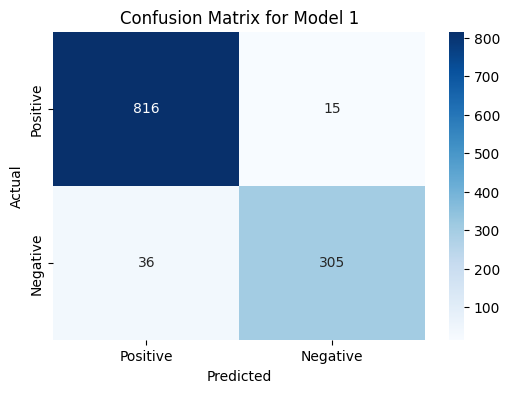

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# model yüklenmesi
model = tf.keras.models.load_model("pneumonia_detection_model.keras")

# Tahminler
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Değerlendirme
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

# confusion matrix
labels = [1, 0]
conf_matrix = confusion_matrix(y_test, y_pred, labels=labels)
print("\nConfusion Matrix:\n", conf_matrix)

# classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Normal", "Pneumonia"]))

# visualization
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Positive", "Negative"], yticklabels=["Positive", "Negative"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Model 1")
plt.show()

## 8.2 Model 2: ResNet-50 Model with one phase of Fine-Tuning

37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step
Accuracy: 0.9010238907849829
Precision: 0.9171528588098017
Recall: 0.9458483754512635
F1 Score: 0.9312796208530806

Confusion Matrix:
 [[786  45]
 [ 71 270]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.86      0.79      0.82       341
   Pneumonia       0.92      0.95      0.93       831

    accuracy                           0.90      1172
   macro avg       0.89      0.87      0.88      1172
weighted avg       0.90      0.90      0.90      1172



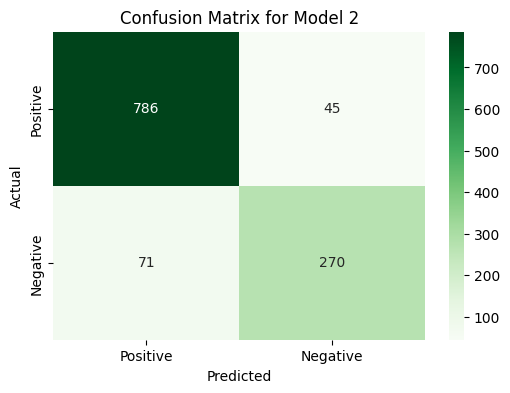

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# model yüklenmesi
model = tf.keras.models.load_model("v1_resnet50.keras")

# Tahminler
y_pred_probs = model.predict(np.concatenate((X_test,X_test,X_test), axis=3))
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Değerlendirme
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

# confusion matrix
labels = [1, 0]
conf_matrix = confusion_matrix(y_test, y_pred, labels=labels)
print("\nConfusion Matrix:\n", conf_matrix)

# classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Normal", "Pneumonia"]))

# visualization
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=["Positive", "Negative"], yticklabels=["Positive", "Negative"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Model 2")
plt.show()

## 8.3 Model 3: ResNet-50 Model with two phases of Fine-Tuning

37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 179ms/step
Accuracy: 0.9334470989761092
Precision: 0.9228295819935691
Recall: 0.9930795847750865
F1 Score: 0.9566666666666667

Confusion Matrix:
 [[861   6]
 [ 72 233]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.76      0.86       305
   Pneumonia       0.92      0.99      0.96       867

    accuracy                           0.93      1172
   macro avg       0.95      0.88      0.91      1172
weighted avg       0.94      0.93      0.93      1172



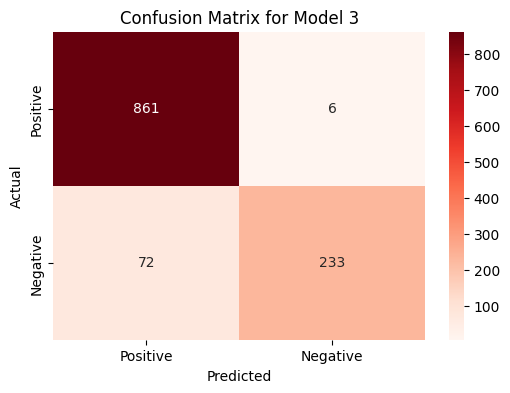

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# model yüklenmesi
model = tf.keras.models.load_model("v3_resnet50.keras")

# Tahminler
y_pred_probs = model.predict(np.concatenate((X_test,X_test,X_test), axis=3))
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Değerlendirme
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

# confusion matrix
labels = [1, 0]
conf_matrix = confusion_matrix(y_test, y_pred, labels=labels)
print("\nConfusion Matrix:\n", conf_matrix)

# classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Normal", "Pneumonia"]))

# visualization
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", xticklabels=["Positive", "Negative"], yticklabels=["Positive", "Negative"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Model 3")
plt.show()